<a href="https://colab.research.google.com/github/oroering8/Bio108Tutorial/blob/main/W7_raster_vector_interactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Raster-vector interactions

Please note that this tutorial directly presents content from [Geocomputation with Python, chapter 5](https://py.geocompx.org/05-raster-vector), specifically section 5.3.

We will begin by installing and importing the following packages and data files:

In [ ]:
! pip install rasterio
! pip install rasterstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 8.8 MB/s eta 0:00:00


In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
import rasterstats
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS

In [ ]:
### Data files we will import
src_srtm = rasterio.open('https://github.com/geocompx/geocompy/raw/refs/heads/main/data/srtm.tif')
src_nlcd = rasterio.open('https://github.com/geocompx/geocompy/raw/refs/heads/main/data/nlcd.tif')
src_grain = rasterio.open('https://github.com/geocompx/geocompy/raw/refs/heads/main/output/grain.tif')
src_elev = rasterio.open('https://github.com/geocompx/geocompy/raw/refs/heads/main/output/elev.tif')
src_dem = rasterio.open('https://github.com/geocompx/geocompy/raw/refs/heads/main/data/dem.tif')
zion = gpd.read_file('https://github.com/geocompx/geocompy/raw/refs/heads/main/data/zion.gpkg')
zion_points = gpd.read_file('https://github.com/geocompx/geocompy/raw/refs/heads/main/data/zion_points.gpkg')
cycle_hire_osm = gpd.read_file('https://github.com/geocompx/geocompy/raw/refs/heads/main/data/cycle_hire_osm.gpkg')
us_states = gpd.read_file('https://github.com/geocompx/geocompy/raw/refs/heads/main/data/us_states.gpkg')
nz = gpd.read_file('https://github.com/geocompx/geocompy/raw/refs/heads/main/data/nz.gpkg')
src_nz_elev = rasterio.open('https://github.com/geocompx/geocompy/raw/refs/heads/main/data/nz_elev.tif')

## Raster extraction

Raster extraction is the process of identifying and returning the values associated with a 'target' raster at specific locations, based on a (typically vector) geographic 'selector' object.

In the following examples, we use a package called **rasterstats**, which is specifically aimed at extracting raster values:

* To *points* or to *lines*, via the `rasterstats.point_query` function
* To *polygons*, via the `rasterstats.zonal_stats` function

### Extraction to points

The simplest type of raster extraction is getting the values of raster cells at specific points.

To demonstrate extraction to points, we will use `zion_points`, which contains a sample of 30 locations within the Zion National Park.


<Axes: >

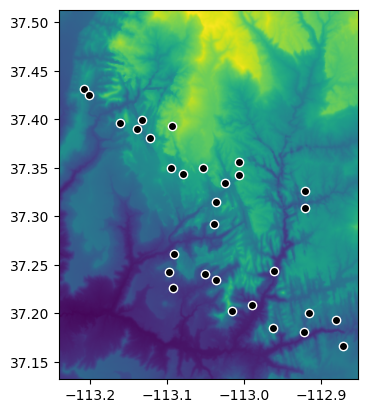

In [ ]:
fig, ax = plt.subplots()
rasterio.plot.show(src_srtm, ax=ax)
zion_points.plot(ax=ax, color='black', edgecolor='white')

The following expression extracts elevation values from `srtm.tif` according to `zion_points`, using `rasterstats.point_query`.

In [ ]:
result1 = rasterstats.point_query(
    zion_points,
    src_srtm.read(1),
    nodata = src_srtm.nodata,
    affine = src_srtm.transform,
    interpolate='nearest'
)

The first two arguments are the vector layer and the array with raster values.
The `nodata` and `affine` arguments are used to align the array values into the CRS, and to correctly treat 'No Data' flags.
Finally, the `interpolate` argument controls the way that the cell values are assigned to the point; `interpolate='nearest'` typically makes more sense, as opposed to the other option `interpolate='bilinear'` which is the default.

The resulting object is a `list` of raster values, corresponding to `zion_points`.
For example, here are the elevations of the first five points.


In [ ]:
result1[:5]

[1802, 2433, 1886, 1370, 1452]

To get a `GeoDataFrame` with the original points geometries (and other attributes, if any), as well as the extracted raster values, we can assign the extraction result into a new column.

In [ ]:
#creating new column storing as elev1 with the result1 object
zion_points['elev1'] = result1
zion_points

,geometry,elev1
0,POINT (-112.91587 37.20013),1802
1,POINT (-113.09369 37.39263),2433
2,POINT (-113.02462 37.33466),1886
3,POINT (-112.96114 37.24326),1370
4,POINT (-112.98976 37.20847),1452
5,POINT (-112.88066 37.19319),1635
6,POINT (-113.05051 37.24061),1380
7,POINT (-113.09525 37.34965),2032
8,POINT (-113.03619 37.31429),1830
9,POINT (-113.20772 37.43165),1860


The function supports extracting from just one raster band at a time.
When passing an array, we can read the required band (as in, `.read(1)`, `.read(2)`, etc.).
When passing a raster file path, we can set the band using the `band_num` argument (the default being `band_num=1`).

### Extraction to lines

Raster extraction is also applicable with line selectors.
The typical line extraction algorithm is to extract one value for each raster cell touched by a line.
However, this particular approach is not recommended to obtain values along the transects, as it is hard to get the correct distance between each pair of extracted raster values.

For line extraction, a better approach is to split the line into many points (at equal distances along the line) and then extract the values for these points using the 'extraction to points' technique.
To demonstrate this, the code below creates `zion_transect`, a straight line going from northwest to southeast of the Zion National Park.


In [ ]:
coords = [[-113.2, 37.45], [-112.9, 37.2]]
zion_transect = shapely.LineString(coords)
print(zion_transect)

LINESTRING (-113.2 37.45, -112.9 37.2)


The utility of extracting heights from a linear selector is illustrated by imagining that you are planning a hike.
The method demonstrated below provides an 'elevation profile' of the route (the line does not need to be straight), useful for estimating how long it will take due to long climbs.

First, we need to create a layer consisting of points along our line (`zion_transect`), at specified intervals (e.g., `250`).
To do that, we need to transform the line into a projected CRS (so that we work with true distances, in $m$), such as UTM.
This requires going through a `GeoSeries`, as **shapely** geometries have no CRS definition nor concept of reprojection.

In [ ]:
#to see what they are go to spatialreference.org
zion_transect_utm = gpd.GeoSeries(zion_transect, crs=4326).to_crs(32612)
zion_transect_utm = zion_transect_utm.iloc[0]

The printout of the new geometry shows this is still a straight line between two points, only with coordinates in a projected CRS. (Contrast `print(zion_transect_utm)`'s output vs. `zion_transect_utm`.)

In [ ]:
print(zion_transect_utm)

LINESTRING (305399.67208180577 4147066.650206682, 331380.8917453843 4118750.0947884847)


Next, we need to calculate the distances, along the line, where points are going to be generated.
We do this using `np.arange`.
The result is a numeric sequence starting at `0`, going up to line `.length`, in steps of `250` ($m$).

In [ ]:
distances = np.arange(0, zion_transect_utm.length, 250)
distances[:7]  ## First 7 distance cutoff points

array([   0.,  250.,  500.,  750., 1000., 1250., 1500.])

The distance cutoffs are used to sample ('interpolate') points along the line.
The **shapely** `.interpolate` method is used to generate the points, which then are reprojected back to the geographic CRS of the raster (EPSG:`4326`).

In [ ]:
zion_transect_pnt = [zion_transect_utm.interpolate(d) for d in distances]
zion_transect_pnt = (
    gpd.GeoSeries(zion_transect_pnt, crs=32612)
    .to_crs(src_srtm.crs)
)
zion_transect_pnt

,0
0,POINT (-113.2 37.45)
1,POINT (-113.19804 37.44838)
2,POINT (-113.19608 37.44675)
3,POINT (-113.19413 37.44513)
4,POINT (-113.19217 37.44351)
...,...
149,POINT (-112.90918 37.20769)
150,POINT (-112.90724 37.20606)
151,POINT (-112.90529 37.20443)
152,POINT (-112.90334 37.2028)


Finally, we extract the elevation values for each point in our transect and combine the information with `zion_transect_pnt` (after 'promoting' it to a `GeoDataFrame`, to accommodate extra attributes), using the point extraction method shown earlier (@sec-extraction-to-points).
We also attach the respective distance cutoff points `distances`.

In [ ]:
result = rasterstats.point_query(
    zion_transect_pnt,
    src_srtm.read(1),
    nodata = src_srtm.nodata,
    affine = src_srtm.transform,
    interpolate='nearest'
)
zion_transect_pnt = gpd.GeoDataFrame(geometry=zion_transect_pnt)
zion_transect_pnt['dist'] = distances
zion_transect_pnt['elev'] = result
zion_transect_pnt

,geometry,dist,elev
0,POINT (-113.2 37.45),0.0,2001
1,POINT (-113.19804 37.44838),250.0,2037
2,POINT (-113.19608 37.44675),500.0,1949
3,POINT (-113.19413 37.44513),750.0,1869
4,POINT (-113.19217 37.44351),1000.0,1783
...,...,...,...
149,POINT (-112.90918 37.20769),37250.0,1854
150,POINT (-112.90724 37.20606),37500.0,1897
151,POINT (-112.90529 37.20443),37750.0,1837
152,POINT (-112.90334 37.2028),38000.0,1841


In [ ]:
zion_transect_pnt.head()

,geometry,dist,elev
0,POINT (-113.2 37.45),0.0,2001
1,POINT (-113.19804 37.44838),250.0,2037
2,POINT (-113.19608 37.44675),500.0,1949
3,POINT (-113.19413 37.44513),750.0,1869
4,POINT (-113.19217 37.44351),1000.0,1783


The information in `zion_transect_pnt`, namely the `'dist'` and `'elev'` attributes, can now be used to draw an elevation profile.

In [ ]:
### First: notice that the Zion NP and raster are not the same CRS!
print(src_srtm.crs)
print(zion.crs)

# Define the target CRS
target_crs = src_srtm.crs

# Reproject the Zion NP in the new CRS
zion_reproj = zion.to_crs(target_crs)

EPSG:4326
PROJCS["UTM Zone 12, Northern Hemisphere",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


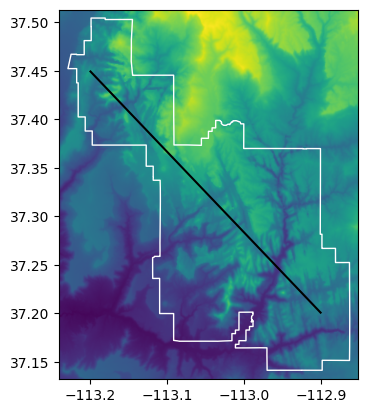

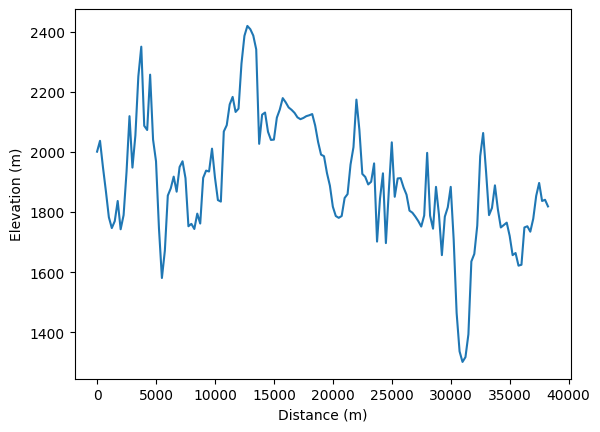

In [ ]:
# Raster and a line transect
fig, ax = plt.subplots()
rasterio.plot.show(src_srtm, ax=ax)
gpd.GeoSeries(zion_transect).plot(ax=ax, color='black')
zion_reproj.plot(ax=ax, color='none', edgecolor='white');
# Elevation profile
fig, ax = plt.subplots()
zion_transect_pnt.set_index('dist')['elev'].plot(ax=ax)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)');

### Extraction to polygons

The final type of geographic vector object for raster extraction is polygons.
Like lines, polygons tend to return many raster values per vector geometry.
For continuous rasters, we typically want to generate summary statistics for raster values per polygon, for example to characterize a single region or to compare many regions.
The generation of raster summary statistics, by polygons, is demonstrated in the code below using `rasterstats.zonal_stats`, which creates a list of summary statistics (in this case a list of length 1, since there is just one polygon).

In [ ]:
result = rasterstats.zonal_stats(
    zion_reproj,
    src_srtm.read(1),
    nodata = src_srtm.nodata,
    affine = src_srtm.transform,
    stats = ['mean', 'min', 'max']
)
result

[{'min': 1122.0, 'max': 2661.0, 'mean': 1818.211830154405}]

In [ ]:
result[0]['max']

2661.0

Transformation of the `list` to a `DataFrame` (e.g., to attach the derived attributes to the original polygon layer), is straightforward with the `pd.DataFrame` constructor.

In [ ]:
pd.DataFrame(result)

,min,max,mean
0,1122.0,2661.0,1818.21183


Because there is only one polygon in the example, a `DataFrame` with a single row is returned.
However, if `zion` was composed of more than one polygon, we would accordingly get more rows in the `DataFrame`.
The result provides useful summaries, for example that the maximum height in the park is `2661` $m$ above see level.

Note the `stats` argument, where we determine what type of statistics are calculated per polygon.
Possible values other than `'mean'`, `'min'`, and `'max'` include:

-   `'count'`---The number of valid (i.e., excluding 'No Data') pixels
-   `'nodata'`---The number of pixels with 'No Data'
-   `'majority'`---The most frequently occurring value
-   `'median'`---The median value

See the documentation of `rasterstats.zonal_stats` for the complete list.
Additionally, the `rasterstats.zonal_stats` function accepts user-defined functions for calculating any custom statistics.

To count occurrences of categorical raster values within polygons, we can use masking combined with `np.unique`, as follows.

In [ ]:
out_image, out_transform = rasterio.mask.mask(
    src_nlcd,
    zion.geometry.to_crs(src_nlcd.crs),
    crop=False,
    nodata=src_nlcd.nodata
)
counts = np.unique(out_image, return_counts=True)
counts

(array([  2,   3,   4,   5,   6,   7,   8, 255], dtype=uint8),
 array([  4205,  98285, 298299, 203701,    235,     62,    679, 852741]))

According to the result, for example, the value `2` ('Developed' class) appears in `4205` pixels within the Zion polygon ([FMI on the NLCD codes here](https://www.usgs.gov/centers/eros/science/annual-nlcd-land-cover-classification)). The figure below illustrates the two types of raster extraction to polygons described above.


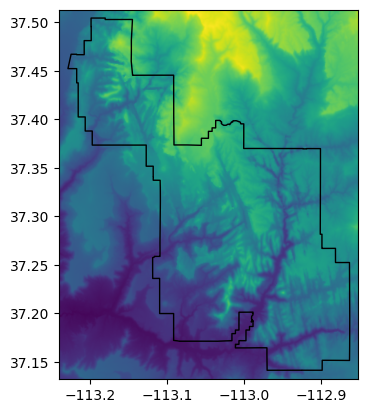

In [ ]:
# Continuous raster
fig, ax = plt.subplots()
rasterio.plot.show(src_srtm, ax=ax)
zion_reproj.plot(ax=ax, color='none', edgecolor='black');

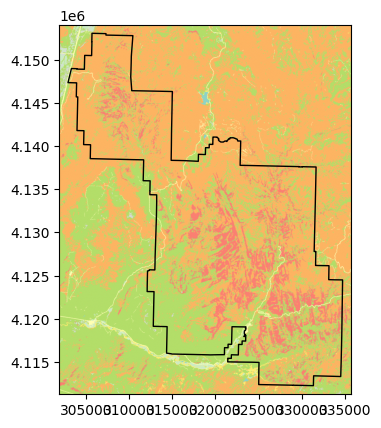

In [ ]:
# Categorical raster
fig, ax = plt.subplots()
rasterio.plot.show(src_nlcd, ax=ax, cmap='Set3')
zion.to_crs(src_nlcd.crs).plot(ax=ax, color='none', edgecolor='black');

In [ ]:
! pip install rasterio
! pip install rasterstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 15.3 MB/s eta 0:00:00


In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
import rasterstats
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
yosemite = gpd.read_file('/content/drive/MyDrive/yosemite_boundary/yose_boundary.shp')

In [ ]:
species_richness = rasterio.open('/content/drive/MyDrive/Species_Richness/Combined_SR_2024.tif')

In [ ]:
with rasterio.open('/content/drive/MyDrive/Species_Richness/Combined_SR_2024.tif') as src:
    profile = src.profile
print(profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 1204, 'height': 592, 'count': 1, 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30000.0, 0.0, -18058187.677929368,
       0.0, -30000.0, 8764905.85562796), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [ ]:
profile.update(dtype=rasterio.float32, count=1, compress="lzw")
print(profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 65535.0, 'width': 1204, 'height': 592, 'count': 1, 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30000.0, 0.0, -18058187.677929368,
       0.0, -30000.0, 8764905.85562796), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [ ]:
species_richness.shape

(592, 1204)

In [ ]:
subset = species_richness[:, 200:300, 0:1200].clip(0, 1)
rgb_subset = np.dstack((subset[4], subset[3], subset[2]))
rgb_subset.shape

TypeError: 'DatasetReader' object is not subscriptable

<Axes: >

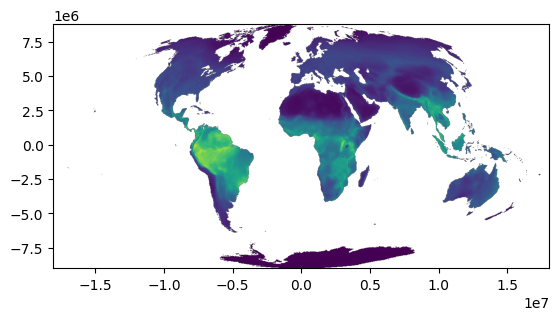

In [ ]:
fig, ax = plt.subplots()
rasterio.plot.show(species_richness, ax=ax)
yosemite.plot(ax=ax, color='black', edgecolor='white')

In [ ]:
print(species_richness.crs)
print(yosemite.crs)

ESRI:54009
EPSG:3857


In [ ]:
# Define the target CRS
target_crs = species_richness.crs

# Reproject the yosemite NP in the new CRS
yosemite_reproj = yosemite.to_crs(target_crs)

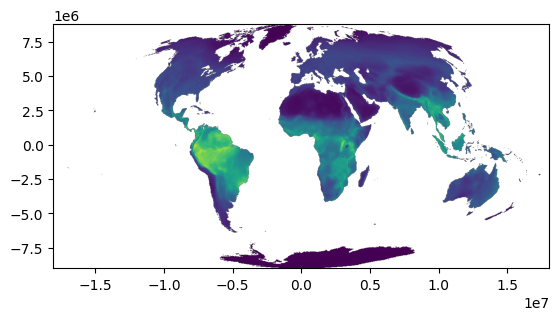

In [ ]:
fig, ax = plt.subplots()
rasterio.plot.show(species_richness, ax=ax)
yosemite.plot(ax=ax, color='black', edgecolor='white')
plt.show()